In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# InceptionV3

In [3]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.InceptionV3(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv2d - False
2 batch_normalization - False
3 activation - False
4 conv2d_1 - False
5 batch_normalization_1 - False
6 activation_1 - False
7 conv2d_2 - False
8 batch_normalization_2 - False
9 activation_2 - False
10 max_pooling2d - False
11 conv2d_3 - False
12 batch_normalization_3 - False
13 activation_3 - False
14 conv2d_4 - False
15 batch_normalization_4 - False
16 activation_4 - False
17 max_pooling2d_1 - False
18 conv2d_8 - False
19 batch_normalization_8 - False
20 activation_8 - False
21 conv2d_6 - False
22 conv2d_9 - False
23 batch_normalization_6 - False
24 batch_normalization_9 - False
25 activation_6 - False
26 activation_9 - False
27 average_pooling2d - False
28 conv2d_5 - False
29 conv2d_7 - False
30 conv2d_10 - False
31 conv2d_11 - False
32 batch_normalization_5 - False
33 batch_normalization_7 - False
34 batch_normalization_10 - False
35 batch_normalization_11 - False
36 activation_5 - False
37 activation_7 - False
38 activation_10 - False
39 activati

In [4]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [5]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = effnet_model(inputs)
flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


C:\Python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [6]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='inceptionv3.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.6889 - precision: 0.8363 - recall: 0.5504 - auc: 0.9725 - f1_score: 0.6289
Epoch 1: val_accuracy improved from -inf to 0.76100, saving model to inceptionv3.hdf5
110/110 [==============================] - 538s 5s/step - loss: 0.9745 - accuracy: 0.6889 - precision: 0.8363 - recall: 0.5504 - auc: 0.9725 - f1_score: 0.6289 - val_loss: 0.6944 - val_accuracy: 0.7610 - val_precision: 0.8112 - val_recall: 0.7073 - val_auc: 0.9837 - val_f1_score: 0.7554
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8879 - precision: 0.9141 - recall: 0.8457 - auc: 0.9972 - f1_score: 0.8786
Epoch 2: val_accuracy improved from 0.76100 to 0.79100, saving model to inceptionv3.hdf5
110/110 [==============================] - 567s 5s/step - loss: 0.3372 - accuracy: 0.8879 - precision: 0.9141 - recall: 0.8457 - auc: 0.9972 - f1_score: 0.8786 - val_loss: 0.5911 - val_accuracy: 0.7910 -

Epoch 17/100
110/110 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9967 - precision: 0.9973 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9970
Epoch 17: val_accuracy did not improve from 0.85600
110/110 [==============================] - 357s 3s/step - loss: 0.0272 - accuracy: 0.9967 - precision: 0.9973 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9970 - val_loss: 0.5037 - val_accuracy: 0.8557 - val_precision: 0.8645 - val_recall: 0.8487 - val_auc: 0.9860 - val_f1_score: 0.8562
Epoch 18/100
110/110 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9984 - precision: 0.9987 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9985
Epoch 18: val_accuracy did not improve from 0.85600
110/110 [==============================] - 365s 3s/step - loss: 0.0215 - accuracy: 0.9984 - precision: 0.9987 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9985 - val_loss: 0.5164 - val_accuracy: 0.8517 - val_precision: 0.8616 - val_recall: 0.8443 - val_auc: 0.9844 - val_f

110/110 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000
Epoch 33: val_accuracy did not improve from 0.86367
110/110 [==============================] - 361s 3s/step - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - val_loss: 0.5817 - val_accuracy: 0.8490 - val_precision: 0.8558 - val_recall: 0.8450 - val_auc: 0.9813 - val_f1_score: 0.8505
Epoch 34/100
110/110 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9994 - precision: 0.9996 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9995
Epoch 34: val_accuracy did not improve from 0.86367
110/110 [==============================] - 362s 3s/step - loss: 0.0076 - accuracy: 0.9994 - precision: 0.9996 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9995 - val_loss: 0.5639 - val_accuracy: 0.8593 - val_precision: 0.8658 - val_recall: 0.8540 - val_auc: 0.9806 - val_f1_score: 0.85

110/110 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000 - f1_score: 0.9999
Epoch 49: val_accuracy did not improve from 0.86367
110/110 [==============================] - 361s 3s/step - loss: 0.0037 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000 - f1_score: 0.9999 - val_loss: 0.6240 - val_accuracy: 0.8597 - val_precision: 0.8645 - val_recall: 0.8527 - val_auc: 0.9772 - val_f1_score: 0.8586
Epoch 50/100
110/110 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994
Epoch 50: val_accuracy did not improve from 0.86367
110/110 [==============================] - 366s 3s/step - loss: 0.0047 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994 - val_loss: 0.6320 - val_accuracy: 0.8603 - val_precision: 0.8650 - val_recall: 0.8567 - val_auc: 0.9771 - val_f1_score: 0.86

110/110 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9923 - precision: 0.9927 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9924
Epoch 65: val_accuracy did not improve from 0.86367
110/110 [==============================] - 361s 3s/step - loss: 0.0229 - accuracy: 0.9923 - precision: 0.9927 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9924 - val_loss: 1.0208 - val_accuracy: 0.8150 - val_precision: 0.8204 - val_recall: 0.8117 - val_auc: 0.9613 - val_f1_score: 0.8162
Epoch 66/100
110/110 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9920 - precision: 0.9924 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9922
Epoch 66: val_accuracy did not improve from 0.86367
110/110 [==============================] - 359s 3s/step - loss: 0.0282 - accuracy: 0.9920 - precision: 0.9924 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9922 - val_loss: 0.8341 - val_accuracy: 0.8437 - val_precision: 0.8474 - val_recall: 0.8423 - val_auc: 0.9677 - val_f1_score: 0.84

110/110 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9985
Epoch 81: val_accuracy did not improve from 0.86367
110/110 [==============================] - 359s 3s/step - loss: 0.0056 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9985 - val_loss: 0.7608 - val_accuracy: 0.8607 - val_precision: 0.8637 - val_recall: 0.8573 - val_auc: 0.9701 - val_f1_score: 0.8606
Epoch 82/100
110/110 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989 - precision: 0.9990 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989
Epoch 82: val_accuracy did not improve from 0.86367
110/110 [==============================] - 360s 3s/step - loss: 0.0035 - accuracy: 0.9989 - precision: 0.9990 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.7656 - val_accuracy: 0.8560 - val_precision: 0.8595 - val_recall: 0.8543 - val_auc: 0.9698 - val_f1_score: 0.85

110/110 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000 - f1_score: 0.9999
Epoch 97: val_accuracy did not improve from 0.86367
110/110 [==============================] - 360s 3s/step - loss: 0.0011 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000 - f1_score: 0.9999 - val_loss: 0.7632 - val_accuracy: 0.8607 - val_precision: 0.8635 - val_recall: 0.8583 - val_auc: 0.9707 - val_f1_score: 0.8609
Epoch 98/100
110/110 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9997
Epoch 98: val_accuracy did not improve from 0.86367
110/110 [==============================] - 359s 3s/step - loss: 0.0013 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9997 - val_loss: 0.7830 - val_accuracy: 0.8567 - val_precision: 0.8586 - val_recall: 0.8543 - val_auc: 0.9695 - val_f1_score: 0.85

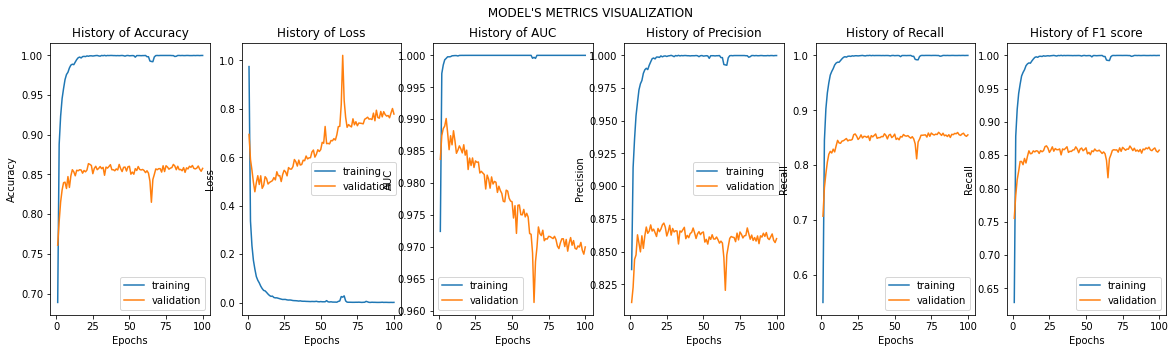

In [7]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [8]:
#model.save('efficientnetB01.hdf5')
model = K.models.load_model("inceptionv3.hdf5", custom_objects={"f1_score": f1_score})
name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = K.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
        if str(layer) != name_seclast_layer:
            model2.add(layer)
        
model2.summary()   

model2.save('inception_mod.hdf5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


# Testing

In [10]:
model = K.models.load_model("inceptionv3.hdf5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 61s 2s/step - loss: 0.5662 - accuracy: 0.8365 - precision: 0.8429 - recall: 0.8315 - auc: 0.9808 - f1_score: 0.8365
Testing Loss:
0.5661540031433105
Testing Accuracy:
0.8364999890327454
Testing Precision:
0.8428788781166077
Testing Recall:
0.8314999938011169
Testing F1-Score:
0.836547315120697
Testing AUC:
0.9807771444320679


C:\Users\aroy8\AppData\Local\Temp/ipykernel_5324/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


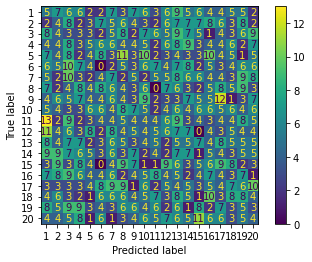

Classification Report
              precision    recall  f1-score   support

           1       0.04      0.05      0.04       100
           2       0.04      0.04      0.04       100
           3       0.02      0.03      0.03       100
           4       0.03      0.03      0.03       100
           5       0.06      0.04      0.05       100
           6       0.00      0.00      0.00       100
           7       0.07      0.07      0.07       100
           8       0.04      0.04      0.04       100
           9       0.03      0.03      0.03       100
          10       0.05      0.05      0.05       100
          11       0.05      0.04      0.04       100
          12       0.06      0.06      0.06       100
          13       0.04      0.05      0.04       100
          14       0.07      0.07      0.07       100
          15       0.06      0.05      0.05       100
          16       0.07      0.07      0.07       100
          17       0.04      0.04      0.04       100
     

In [11]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))